In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")

from data.GDGT_datasets import load_duncan

# TODOs

- [ ] save and load inference data
- [ ] save and load model , e.g., [`ModelBuilder`](https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html)
- [x] load observed data (e.g., from Excel spreadsheet) separately, e.g., via `load_data("Duncan 2023")`
- [x] move *TEX$_{86}$* and *Ring Index* into separate notebooks (or models)

# Regression model for TEX86

Based on [the TEX$_\textsf{86}$ Wikipedia article](https://en.wikipedia.org/wiki/TEX86#Calibrations).

In [2]:
# Load dataset

compound_names, sst_name, df_all = load_duncan(age_max=0.16)

N_SAMPLES = 50

observed = df_all[compound_names].values
sst = df_all[sst_name].values

# N_TEST = 100
# idx_valid = np.random.choice(np.arange(len(sst)),N_TEST)
# idx_valid = np.linspace(0,len(sst)-len(sst)//N_TEST,N_TEST).astype(int) + np.random.randint(0,len(sst)//N_TEST,size=N_TEST)

# observed = observed[idx_valid]
# sst = sst[idx_valid]

print(observed.shape)
print(sst.shape)


print(observed.shape,sst.shape)
with pm.Model() as model_tex86:
    GDGTs = pm.MutableData("GDGTs", observed)
    GDGT_2_ratio = (GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])/(GDGTs[:,1]+GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])
    print(GDGT_2_ratio.eval().shape)
    a = pm.Normal("a",30,10)
    b = pm.Normal("b",30,10)
    σ = pm.HalfNormal("σ",10)
    SST_TEX86H  = pm.Normal("SST_TEX86H",mu=a+b*pm.math.log(GDGT_2_ratio),sigma=σ,observed=sst)
    idata_tex86 = pm.sample_prior_predictive(samples=N_SAMPLES)  

(1291, 6)
(1291,)
(1291, 6) (1291,)


/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in SST_TEX86H contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x18E451B60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed, SST_TEX86H_unobserved, a, b, σ]


(1291,)


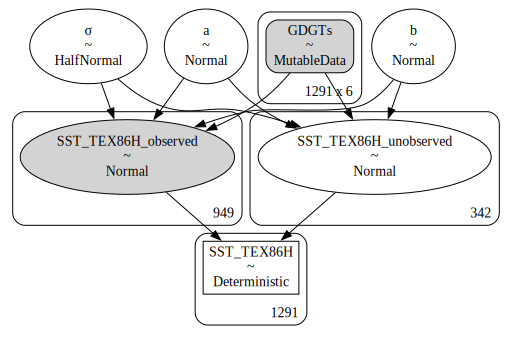

In [3]:
pm.model_to_graphviz(model_tex86)

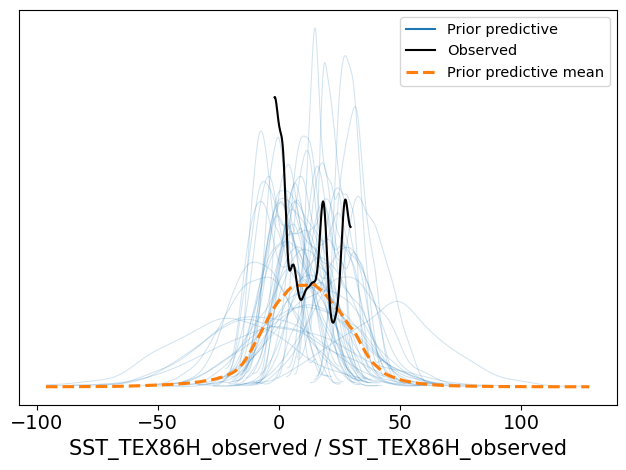

In [4]:
az.plot_ppc(idata_tex86,group="prior")
plt.tight_layout()

In [5]:
with model_tex86:
    idata_tex86.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, σ, SST_TEX86H_unobserved]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 54 seconds.


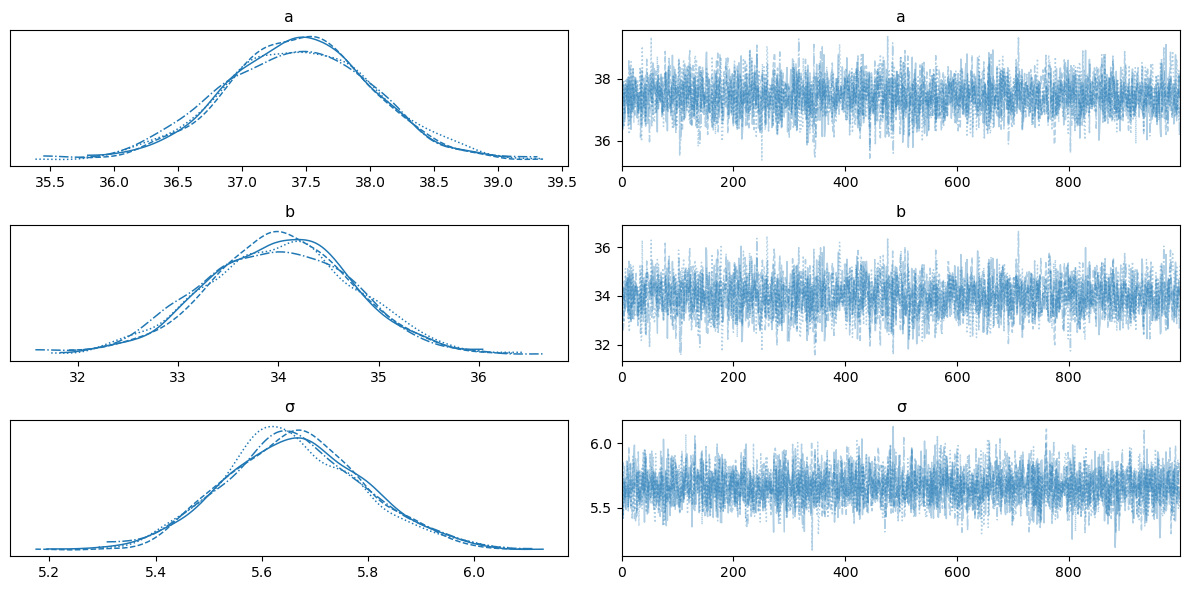

In [6]:
var_names = ["a","b"]+["σ"]
ax = az.plot_trace(idata_tex86,var_names=var_names)
plt.tight_layout()

In [7]:
az.summary(idata_tex86,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,37.436,0.576,36.278,38.442,0.010,0.007,3303.0,2841.0,1.0
b,34.004,0.740,32.567,35.353,0.014,0.010,2761.0,2913.0,1.0
σ,5.662,0.132,5.418,5.912,0.002,0.002,3647.0,2885.0,1.0


In [8]:
with model_tex86:
    idata_tex86.extend(pm.sample_posterior_predictive(idata_tex86))

/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1907CE7A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed]


<Axes: xlabel='SST_TEX86H_observed / SST_TEX86H_observed'>

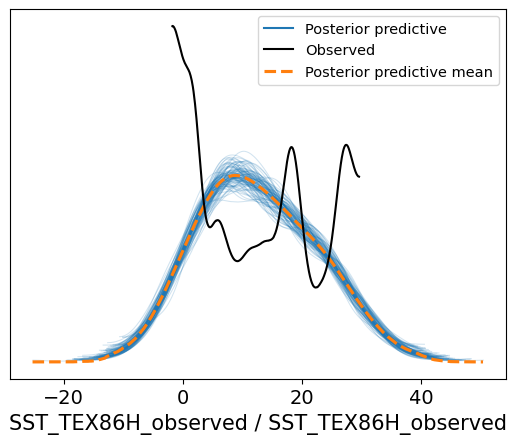

In [9]:
az.plot_ppc(idata_tex86, num_pp_samples=100)

(342,)


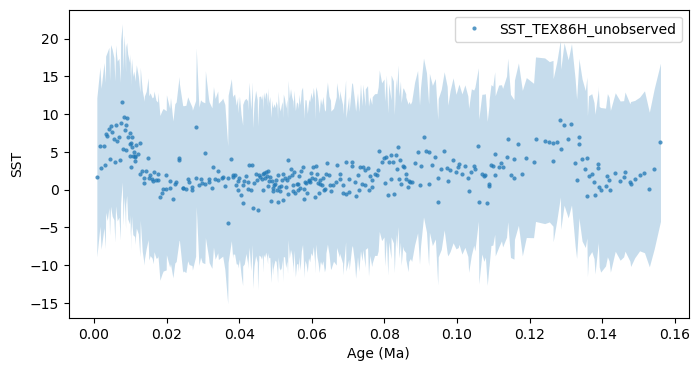

In [10]:
# Stack samples into a single dimension
stacked = az.extract(idata_tex86)

fig, ax = plt.subplots(1,1,figsize=(8,4))

unobserved = "SST_TEX86H_unobserved"
# mean
y = stacked[unobserved].mean(dim="sample")#*sst_sd+sst_mu
# 94% HDI
y_hdi_lo = stacked[unobserved].quantile(0.03,dim="sample")#*sst_sd+sst_mu
y_hdi_hi = stacked[unobserved].quantile(0.97,dim="sample")#*sst_sd+sst_mu
print(y.shape)

age = df_all[~df_all["calibration"]]["Age (Ma)"]

age_max = 0.16
this_age = age[age<age_max]
this_y = y[age.values<age_max]
this_y_hdi_lo = y_hdi_lo[age.values<age_max]
this_y_hdi_hi = y_hdi_hi[age.values<age_max]
l, = ax.plot(this_age,this_y,ls='',marker='.',mew=0,alpha=0.75,label=unobserved)
ax.fill_between(this_age,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.25)
ax.set_ylabel("SST")
ax.set_xlabel("Age (Ma)")

ax.legend();

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc

Last updated: Thu Nov 09 2023

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.17.2

pymc: 5.9.1

sys       : 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:09:20) [Clang 16.0.6 ]
matplotlib: 3.8.1
pymc      : 5.9.1
arviz     : 0.16.1
numpy     : 1.24.4

Watermark: 2.4.3

